In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

In [8]:
df_train = pd.read_csv('./train.csv', index_col=0)
df_test = pd.read_csv('./test.csv', index_col=0)

In [9]:
df_train.isnull().sum()

age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
smoking                0
dtype: int64

In [23]:
X_train = df_train.drop('smoking', axis=1)
y_train = df_train['smoking']
X_test = df_test

In [24]:
X, y = X_train, y_train

In [25]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### XG Boost Classification

In [26]:
xgbm = XGBClassifier(random_state=42)

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
params = {'max_depth': [2,3,4,5,6,None],
          'learning_rate':np.linspace(0.001, 0.999, 10),
          'n_estimators':[50, 100, 150]}

gcv_xgbm = GridSearchCV(xgbm, param_grid=params,verbose=3, cv=kfold, scoring='neg_log_loss')
gcv_xgbm.fit(X, y)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV 1/5] END learning_rate=0.001, max_depth=2, n_estimators=50;, score=-0.672 total time=   0.3s
[CV 2/5] END learning_rate=0.001, max_depth=2, n_estimators=50;, score=-0.672 total time=   0.2s
[CV 3/5] END learning_rate=0.001, max_depth=2, n_estimators=50;, score=-0.672 total time=   0.2s
[CV 4/5] END learning_rate=0.001, max_depth=2, n_estimators=50;, score=-0.672 total time=   0.2s
[CV 5/5] END learning_rate=0.001, max_depth=2, n_estimators=50;, score=-0.672 total time=   0.2s
[CV 1/5] END learning_rate=0.001, max_depth=2, n_estimators=100;, score=-0.660 total time=   0.3s
[CV 2/5] END learning_rate=0.001, max_depth=2, n_estimators=100;, score=-0.660 total time=   0.4s
[CV 3/5] END learning_rate=0.001, max_depth=2, n_estimators=100;, score=-0.659 total time=   0.4s
[CV 4/5] END learning_rate=0.001, max_depth=2, n_estimators=100;, score=-0.660 total time=   0.3s
[CV 5/5] END learning_rate=0.001, max_depth=2, n_estimators=

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_typ...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': array([0.001     , 0.11188889, 0.22277778, 0.33366667, 0.44455556,
       0.55544444, 0.66633333, 0.77722222, 0.88811111, 0.999     ]),
                         'max_depth': [2, 3, 4, 5, 6, None],
                         'n_estimators': [50, 100, 150]},
             scoring='neg_log_loss', verbose=3)

In [27]:
print(gcv_xgbm.best_params_)
print(gcv_xgbm.best_score_)

{'learning_rate': 0.22277777777777777, 'max_depth': 5, 'n_estimators': 150}
-0.44274658485141904


In [28]:
bm_xgbm = gcv_xgbm.best_estimator_
bm_xgbm.feature_names_in_

array(['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine',
       'AST', 'ALT', 'Gtp', 'dental caries'], dtype='<U19')

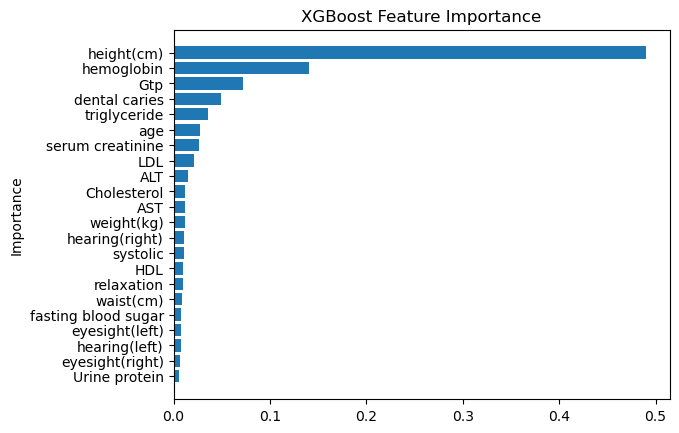

In [29]:
bm_xgbm = gcv_xgbm.best_estimator_

df_imp = pd.DataFrame({ 'variable':bm_xgbm.feature_names_in_,
                        'importance':bm_xgbm.feature_importances_})

df_imp = df_imp[df_imp['importance']>0.0001]
df_imp = df_imp.sort_values(by='importance')
plt.barh(df_imp['variable'] ,df_imp['importance'])
plt.title("XGBoost Feature Importance")
plt.ylabel("Importance")
plt.show()

In [37]:
y_pred_prob = bm_xgbm.predict_proba(X_test)[:,1]

df_xgbm = pd.DataFrame({
    'id': df_test.index,
    'smoking': y_pred_prob
})
df_xgbm.to_csv('submission_xgbm.csv', index=False)

### Light GBM

In [40]:
lgbm = LGBMClassifier(random_state=42)
params = {'max_depth': [2,3,4,5,6,None],
          'learning_rate':np.linspace(0.001, 0.999, 10),
          'n_estimators':[50, 100, 150]}

gcv_lgbm = GridSearchCV(lgbm, param_grid=params,verbose=3, cv=kfold, scoring='neg_log_loss')
gcv_lgbm.fit(X, y)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 55722, number of negative: 71682
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005531 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2144
[LightGBM] [Info] Number of data points in the train set: 127404, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437365 -> initscore=-0.251865
[LightGBM] [Info] Start training from score -0.251865
[CV 1/5] END learning_rate=0.001, max_depth=2, n_estimators=50;, score=-0.672 total time=   0.5s
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 55722, number of negative: 71683
[LightGBM] [Info] Auto-choosing row-wise multi-thr

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LGBMClassifier(random_state=42),
             param_grid={'learning_rate': array([0.001     , 0.11188889, 0.22277778, 0.33366667, 0.44455556,
       0.55544444, 0.66633333, 0.77722222, 0.88811111, 0.999     ]),
                         'max_depth': [2, 3, 4, 5, 6, None],
                         'n_estimators': [50, 100, 150]},
             scoring='neg_log_loss', verbose=3)

In [41]:
print(gcv_lgbm.best_params_)
print(gcv_lgbm.best_score_)

{'learning_rate': 0.11188888888888888, 'max_depth': 6, 'n_estimators': 150}
-0.44295610762013765


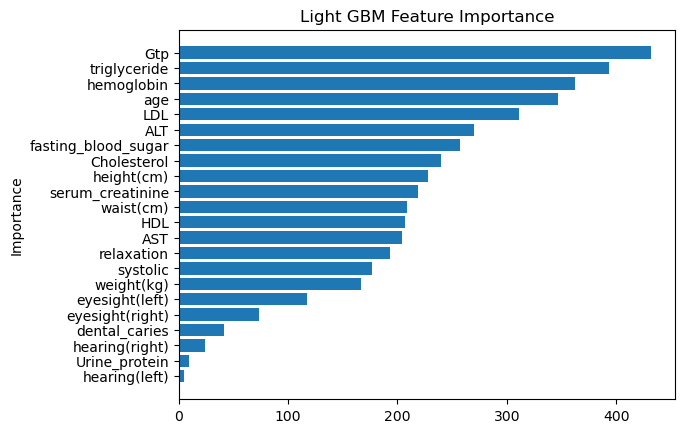

In [42]:
bm_lgbm = gcv_lgbm.best_estimator_

df_imp = pd.DataFrame({ 'variable':bm_lgbm.feature_name_,
                        'importance':bm_lgbm.feature_importances_})

df_imp = df_imp[df_imp['importance']>0.0001]
df_imp = df_imp.sort_values(by='importance')
plt.barh(df_imp['variable'] ,df_imp['importance'])
plt.title("Light GBM Feature Importance")
plt.ylabel("Importance")
plt.show()

In [47]:
y_pred_prob = bm_lgbm.predict_proba(X_test)[:,1]

df_lgbm = pd.DataFrame({
    'id': df_test.index,
    'smoking': y_pred_prob
})
df_lgbm.to_csv('submission_lgbm.csv', index=False)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


### Cat Boost

In [44]:
cgbm = CatBoostClassifier(random_state=42)
params = {'max_depth': [2,3,4,5,6,None],
          'learning_rate':np.linspace(0.001, 0.999, 10),
          'n_estimators':[50, 100, 150]}

gcv_cgbm = GridSearchCV(cgbm, param_grid=params,verbose=3,
                   cv=kfold, scoring='neg_log_loss')
gcv_cgbm.fit(X, y)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
0:	learn: 0.6927596	total: 64.1ms	remaining: 3.14s
1:	learn: 0.6923715	total: 75.6ms	remaining: 1.81s
2:	learn: 0.6919717	total: 85.2ms	remaining: 1.33s
3:	learn: 0.6915787	total: 93.6ms	remaining: 1.08s
4:	learn: 0.6912080	total: 100ms	remaining: 903ms
5:	learn: 0.6908217	total: 107ms	remaining: 786ms
6:	learn: 0.6904438	total: 114ms	remaining: 698ms
7:	learn: 0.6900584	total: 120ms	remaining: 632ms
8:	learn: 0.6896873	total: 128ms	remaining: 582ms
9:	learn: 0.6892916	total: 134ms	remaining: 537ms
10:	learn: 0.6889172	total: 142ms	remaining: 502ms
11:	learn: 0.6885375	total: 148ms	remaining: 468ms
12:	learn: 0.6881536	total: 155ms	remaining: 441ms
13:	learn: 0.6877815	total: 161ms	remaining: 415ms
14:	learn: 0.6873888	total: 168ms	remaining: 391ms
15:	learn: 0.6870281	total: 174ms	remaining: 369ms
16:	learn: 0.6866433	total: 180ms	remaining: 350ms
17:	learn: 0.6862778	total: 187ms	remaining: 333ms
18:	learn: 0.6859026	tota

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=<catboost.core.CatBoostClassifier object at 0x7f3de44d2890>,
             param_grid={'learning_rate': array([0.001     , 0.11188889, 0.22277778, 0.33366667, 0.44455556,
       0.55544444, 0.66633333, 0.77722222, 0.88811111, 0.999     ]),
                         'max_depth': [2, 3, 4, 5, 6, None],
                         'n_estimators': [50, 100, 150]},
             scoring='neg_log_loss', verbose=3)

In [45]:
print(gcv_cgbm.best_params_)
print(gcv_cgbm.best_score_)

{'learning_rate': 0.22277777777777777, 'max_depth': 6, 'n_estimators': 150}
-0.4435427914029108


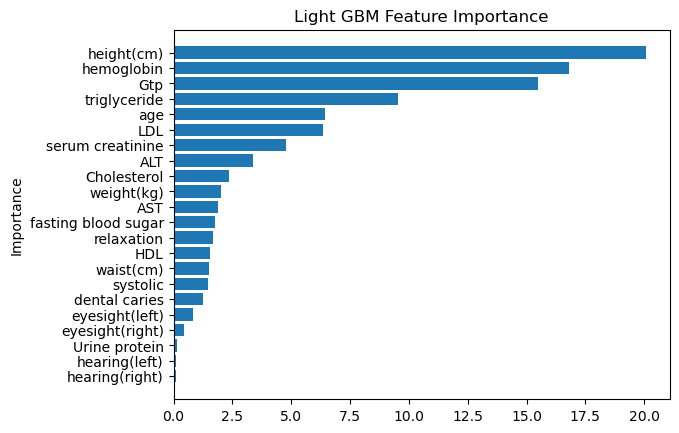

In [46]:
bm_cgbm = gcv_cgbm.best_estimator_

df_imp = pd.DataFrame({ 'variable':bm_cgbm.feature_names_,
                        'importance':bm_cgbm.feature_importances_})

df_imp = df_imp[df_imp['importance']>0.0001]
df_imp = df_imp.sort_values(by='importance')
plt.barh(df_imp['variable'] ,df_imp['importance'])
plt.title("Light GBM Feature Importance")
plt.ylabel("Importance")
plt.show()

In [48]:
y_pred_prob = bm_cgbm.predict_proba(X_test)[:,1]

df_cgbm = pd.DataFrame({
    'id': df_test.index,
    'smoking': y_pred_prob
})
df_cgbm.to_csv('submission_cgbm.csv', index=False)